# Деревья решений
Деревья решений являются широко используемыми моделями для решения задач регрессии и классификации. При построении модели происходит выстраивание иерархии правил "если, то ...", приводящей к решению. Эти правила называются **тестами (tests)**. Тесты для двумерных признаков можно представить как вопрос, ответ на который да или нет. Для непрерывных признаков используются тесты вида *Признак i больше значения val?*
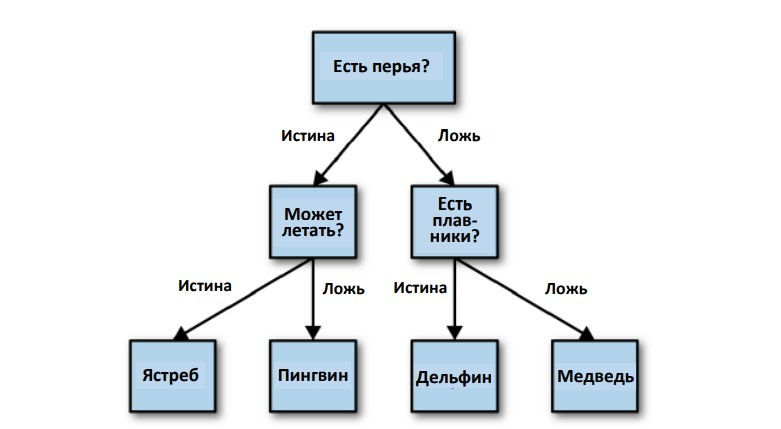  
При обучении выбираются те тесты, которые наиболее информативны (те, которые наилучшим образом отделяют классы друг от друга)
Например, выбор теста $x[1] <= 0.0596$ дает разделение некоторого набора данных следующим образом
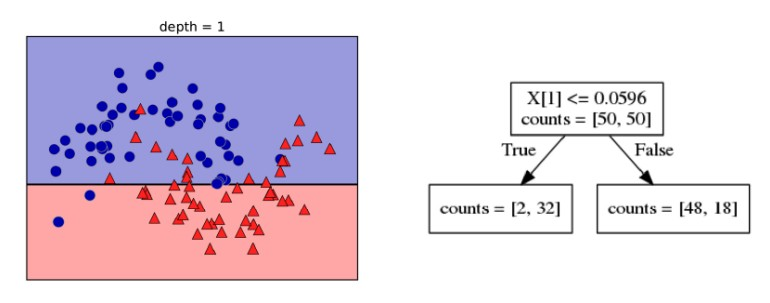  
Если тест верен, то новой точка данных относится к левому узлу, который содержит 2 точки, относящиеся к классу 0 и 32 точки, относящиеся к классу 1.

Можно усложнить дерево, если повторить процесс поиска наиболее информативного теста в каждом из двух получившихся узлов:
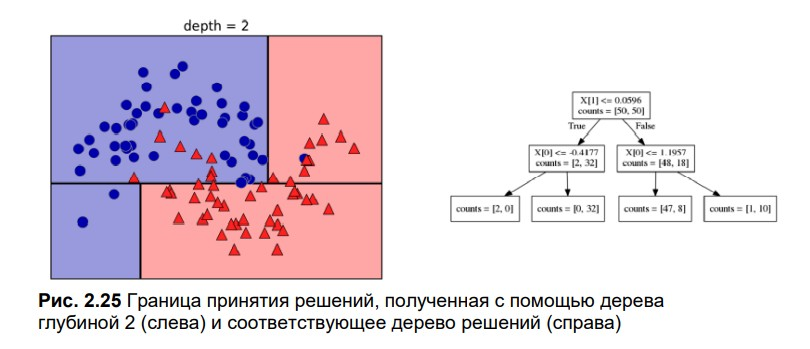
Продолжая разбиение, в итоге получим бинарное дерево решений, в котором каждый узел соответствует некоторое области пространства признаков, и с этой областью ассоциирован определенный класс (или определенное значение). Если в листе действительно содержатся точки данных, относящиеся к одному и тому же значению целевой переменной, то такой лист называют **чистым (pure)**.


**Как получают прогноз для новой точки данных**  
 - *Классификация*: сначала выясниют, в какую область разбиения пространства признаков попала данная точка. Затем определяют преимущественный класс в этой области. Новой точке данных присваивается этот класс.
 - *Регрессия*: находится лист, в который попадает новая точка данных. Целевой переменной новой точки присваивается среднее значение целевой переменной в соответствующей листу области пространства признаков.
 

**Контроль сложности**  
Если строить дерево до тех пор, пока все листья не станут чистыми, то будет получена модель, имеющая 100% точность на обучающей выборке. Такая модель будет максимально переобучена. Граница принятия решения будет фокусироваться на отдельных точка-выбросах и особенностях обучающей выборки.  
Есть 2 общепринятые стратегии, позволяющие предотвратить переобучение в деревьях решений:  
 - *pre-pruning (предварительная обрезка)* - ранняя остановка построения дерева на основе *ограничений*: максимальное количество листьев, максимальная глубина дерева, минимальное количество наблюдений в узле
 - *post-pruning (обрезка)* - построение дерева с последующием удалением или сокращением малоинформативных узлов  
 
 В scikit-learn реализована только первая стратегия

## Классификация

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data,
                                                    cancer.target,
                                                    train_size=0.7,
                                                    random_state=13)
tree_v0 = DecisionTreeClassifier().fit(X_train, y_train)
print(f'Глубина получившегося дерева: {tree_v0.get_depth()}')
print(f'Правильность на обучающем наборе: {tree_v0.score(X_train, y_train)}')
print(f'Правильность на тестовом наборе: {tree_v0.score(X_test, y_test)}')
print(f'Предсказанные метки: {tree_v0.predict(X_test[35:40])} \nИстинные метки: {y_test[35:40]} ')

Глубина получившегося дерева: 7
Правильность на обучающем наборе: 1.0
Правильность на тестовом наборе: 0.9005847953216374
Предсказанные метки: [0 1 1 1 0] 
Истинные метки: [1 1 1 1 1] 


 Если не ограничить глубину, то дерево может быть сколь угодно сложным и глубоким. По этой причине необрезанные деревья склонны к переобучению. Установим дополнительные параметры для дерева

In [27]:
# пусть глубина = 4,
# то есть ПОСЛЕДОВАТЕЛЬНО можно задать только 4 вопроса
tree_v1 = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)
print(f'Правильность на обучающем наборе: {tree_v1.score(X_train, y_train)}')
print(f'Правильность на тестовом наборе: {tree_v1.score(X_test, y_test)}')
print(f'Предсказанные метки: {tree_v1.predict(X_test[35:40])} \nИстинные метки: {y_test[35:40]} ')

Правильность на обучающем наборе: 0.9899497487437185
Правильность на тестовом наборе: 0.9298245614035088
Предсказанные метки: [0 1 1 1 0] 
Истинные метки: [1 1 1 1 1] 


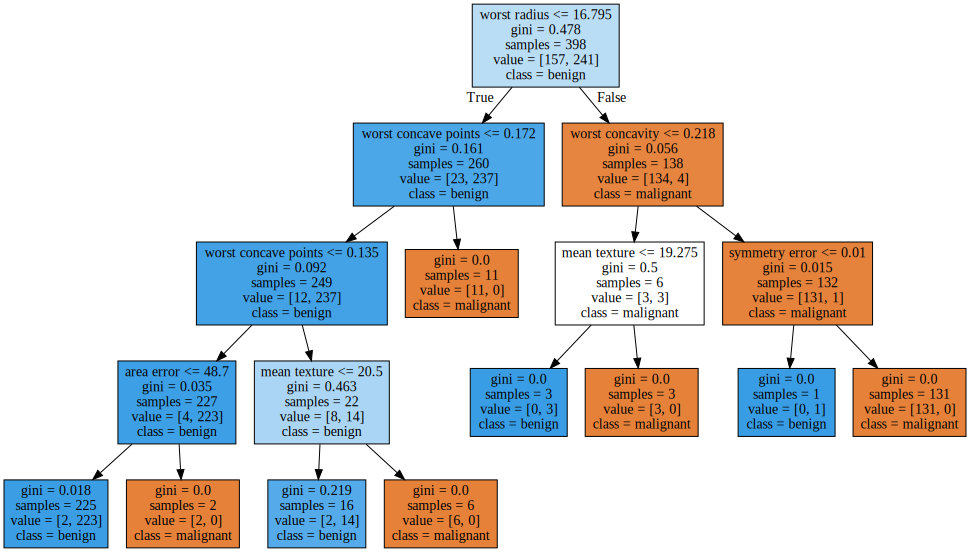

In [32]:
# визуализация дерева
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree_v1, out_file=None,
                           class_names=cancer.target_names,
                           feature_names=cancer.feature_names,
                           filled=True)
graph = graphviz.Source(dot_data)
graph

In [33]:
# экспорт дерева в pdf файл
import pydotplus

graph_to_pdf = pydotplus.graph_from_dot_data(dot_data)
graph_to_pdf.write_pdf('tree with depth = 4 for cancer dataset.pdf')

True

Один из полезных способов исследования дерева решений заключается в том, чтобы выяснить, какие узлы содержат наибольшее количество данных. Параметр **samples** отвечает на общее число точек обучающей выборки в данном узле, а параметр **value** указаывает на распределение точек по классам.


Мы также можем оценить дерево не только с помощью визуализации, но и задействуя некоторые показатели:  
- *feature importance (важность признаков)* - насколько важен каждый признак с точки зрения получения решения (это число от 0 до 1 для каждого признака; важности признаков в сумме дают 1)

In [36]:
print('feature importance:')
for name, feat_imp in zip(cancer.feature_names, tree_v1.feature_importances_):
    print(f'name = {name}, importance = {round(feat_imp, 3)}')

feature importance:
name = mean radius, importance = 0.0
name = mean texture, importance = 0.053
name = mean perimeter, importance = 0.0
name = mean area, importance = 0.0
name = mean smoothness, importance = 0.0
name = mean compactness, importance = 0.0
name = mean concavity, importance = 0.0
name = mean concave points, importance = 0.0
name = mean symmetry, importance = 0.0
name = mean fractal dimension, importance = 0.0
name = radius error, importance = 0.0
name = texture error, importance = 0.0
name = perimeter error, importance = 0.0
name = area error, importance = 0.021
name = smoothness error, importance = 0.0
name = compactness error, importance = 0.0
name = concavity error, importance = 0.0
name = concave points error, importance = 0.0
name = symmetry error, importance = 0.011
name = fractal dimension error, importance = 0.0
name = worst radius, importance = 0.769
name = worst texture, importance = 0.0
name = worst perimeter, importance = 0.0
name = worst area, importance = 0.

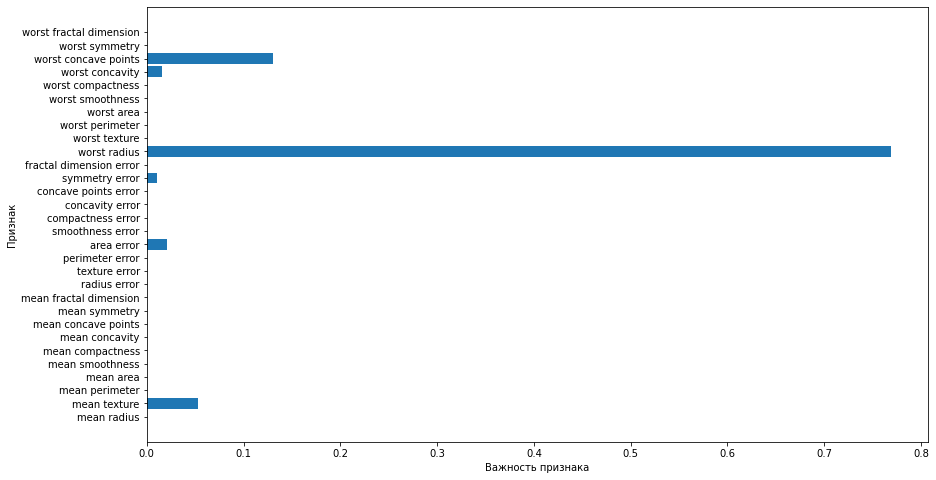

In [48]:
# можно визуализаровать важность признаков
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_feature_importance(model):
    n_features = len(cancer.feature_names)
    plt.figure(figsize=(14,8))
    plt.barh(range(n_features),
             model.feature_importances_,
             align='center')
    plt.yticks(np.arange(n_features),
              cancer.feature_names)
    plt.xlabel('Важность признака')
    plt.ylabel('Признак')
    
plot_feature_importance(tree_v1)

Можно заметить, что самый информативный признак - *worst radius* - был использован в самом первом тесте.  
В отличие от коэффициентов линейной модели важности признаков всегда положительны и они не указывают на взаимосвязь с каким-то конкретным классом. Важности признаков указывают на их **информативность**

## Регрессия
Существенной особенность деревьев решений для регресси является то, что они не могут делать прогнозы для точек, не входящих в область обучающих данных.  

Рассмотрим на конкретном примере. Есть исторические данные о ценах на компьютерную память.

In [54]:
import pandas as pd
ram = pd.read_csv('C:/Users/tolik/information_technology/Computer Science/MachineLearning/Untitled Folder/introduction_to_ml_with_python/data/ram_price.csv')
ram.head()

,Unnamed: 0,date,price
0,0,1957.0,411041792.0
1,1,1959.0,67947725.0
2,2,1960.0,5242880.0
3,3,1965.0,2642412.0
4,4,1970.0,734003.0


Text(0, 0.5, 'Цена')

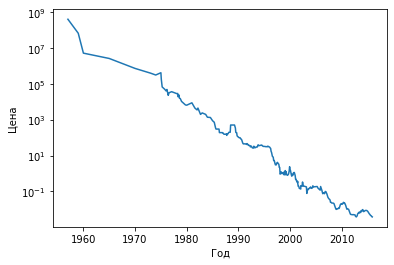

In [55]:
plt.semilogy(ram.date, ram.price)
plt.xlabel('Год')
plt.ylabel('Цена')

Сделаем прогноз по цене на период после 2000 года, используя данные до этого момента

In [63]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

train = ram[ram.date < 2000]
test = ram[ram.date >= 2000]
X_train, y_train = train.date[:, np.newaxis], np.log(train.price)
# используется логпреобразование, чтобы взаимосвязь была простой (как на графике)

tree = DecisionTreeRegressor(max_depth=4).fit(X_train, y_train)
lin_model = LinearRegression().fit(X_train, y_train)

# сделаем прогноз по всем данным
X_all = ram.date[:, np.newaxis]

predicted_tree = tree.predict(X_all)
predicted_linmod = lin_model.predict(X_all)

# экспоненцируем, чтобы обратить логпреобазование и получить цены
price_tree = np.exp(predicted_tree)
price_lin = np.exp(predicted_linmod)

<ipython-input-63-444a49379b4d>:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X_train, y_train = train.date[:, np.newaxis], np.log(train.price)
<ipython-input-63-444a49379b4d>:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X_all = ram.date[:, np.newaxis]


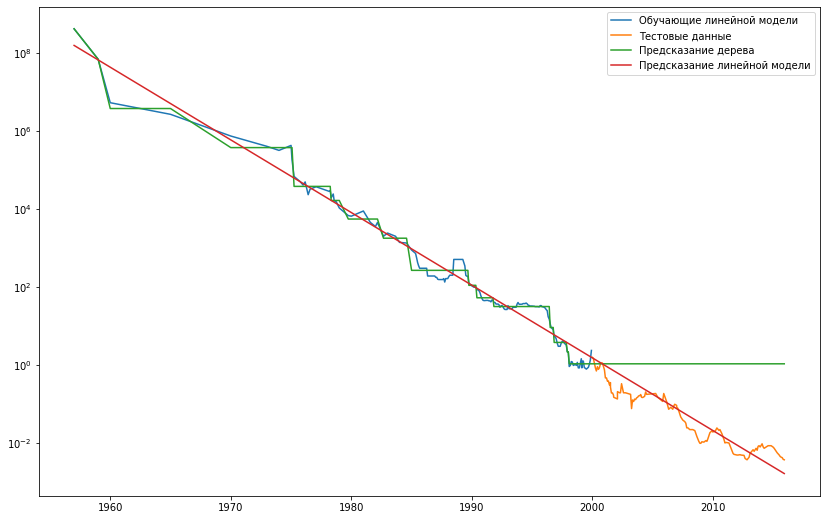

In [68]:
plt.figure(figsize=(14,9))
plt.semilogy(train.date, train.price, label = 'Обучающие линейной модели')
plt.semilogy(test.date, test.price, label = 'Тестовые данные')
plt.semilogy(ram.date, price_tree, label = 'Предсказание дерева')
plt.semilogy(ram.date, price_lin, label = 'Предсказание линейной модели')
plt.legend()

# Резюме
- Параметры, которые позволяют контролировать сложность модели - это параметры предварительной обработки (обычно достаточно выбрать одну из стратегий - настройка *max_depth*, либо *max_leaf_nodes*, либо *min_samples_leaf*)  
- Полученная модель может быть визуализирована  
- Деревья не требуют нормализации данных (можно использовать без масштабирования, когда есть признаки в разных шкалах измерения)  
- Очень тонкая грань между переобучением и недообучением